In [1]:
using Pkg
Pkg.activate((@__DIR__) * "/../one_flav_env")

using LHEF
using LorentzVectorHEP
using DataFrames
using CSV
using StaticArrays
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm
using Optim
using PythonPlot

golden_ratio = (1+sqrt(5))/2

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

MG_RESULTS_DIR = (@__DIR__) * "/../madgraph/data/"
FIGDIR = "./"

# make sure these match what the script has output
DIR_llνν = MG_RESULTS_DIR * "mumu_to_llvv/"

PROMPT_DIR = "prompt_scan/"
DIR_φφ = MG_RESULTS_DIR * PROMPT_DIR * "mumu_to_phiphi/"
DIR_llχχ = MG_RESULTS_DIR * PROMPT_DIR * "mumu_to_llchichi/"
DIR_VVφφ = MG_RESULTS_DIR * PROMPT_DIR * "VV_to_phiphi/"
DIR_VVχχ = MG_RESULTS_DIR * PROMPT_DIR * "VV_to_llchichi/"

RUN_RESULTS_FILENAME = "run_info.csv"
SUMMARY_FILENAME = "dilepton_summary.csv"

SR_table_3 = CSV.read("table_rts=3.csv", DataFrame)
SR_table_10 = CSV.read("table_rts=10.csv", DataFrame)
SR_mins_3 = [Vector(SR_table_3[i,1:3]) for i in 1:nrow(SR_table_3)]
SR_mins_10 = [Vector(SR_table_10[i,1:3]) for i in 1:nrow(SR_table_10)]
;

  Activating project at `~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/one_flav_env`


In [2]:
include((@__DIR__) * "/prompt_utils.jl")
using .Prompt
;

In [3]:
function get_runs_at_rts(rts_tev; bkg_dir=DIR_llνν, mumu_dir=DIR_llχχ, 
    vbf_dir=DIR_VVχχ)

    rts_gev = Float64(rts_tev)*1e3

    mumu_info = load_run_info(mumu_dir)
    vbf_info = load_run_info(vbf_dir)

    mumu_idxs = findall(x -> x == rts_gev, mumu_info[:,1])
    vbf_idxs = findall(x -> x == rts_gev, vbf_info[:,1])

    if !(mumu_idxs == vbf_idxs)
        throw(ArgumentError("mumu and vbf runs don't match up..."))
    end

    mumu_info = mumu_info[mumu_idxs,:]
    vbf_info = vbf_info[vbf_idxs,:]

    bkg_info, bkg_summary = get_bkg_at_rts(rts_tev, bkg_dir)

    return (rts=rts_gev, run_ids=mumu_idxs, mphis=mumu_info.mphi,
            mumu_xsecs=mumu_info.xsec, vv_xsecs=vbf_info.xsec,
            bkg_summary=bkg_summary, bkg_xsec=bkg_info.xsec[1],
            mumu_dir=mumu_dir, vbf_dir=vbf_dir)
end

function get_run_with_summary(rts_runs, idx)
    mumu_summary = load_summary(rts_runs.mumu_dir * 
                     dir_runx(rts_runs.run_ids[idx]))
    vv_summary = load_summary(rts_runs.vbf_dir * 
                     dir_runx(rts_runs.run_ids[idx]))
    
    return (rts=rts_runs.rts, mphi=rts_runs.mphis[idx],
        mumu_summary=mumu_summary, vv_summary=vv_summary,
        mumu_xsec=rts_runs.mumu_xsecs[idx], vv_xsec=rts_runs.vv_xsecs[idx],
        bkg_summary=rts_runs.bkg_summary, bkg_xsec=rts_runs.bkg_xsec)
end
;

In [4]:
rts3_runs = get_runs_at_rts(3)
rts10_runs = get_runs_at_rts(10)
;

# Discovery Regions

In [14]:
function sig_ranges(runs, lumi, SR_table, ε)

    mll_mins = SR_table[!,"mll_min [GeV]"]
    ptll_mins = SR_table[!,"ptll_min [GeV]"]
    mt2_mins = SR_table[!,"mt2_min [GeV]"]

    res = zeros(Float64, (length(runs.mphis), nrow(SR_table)))
    resb = zeros(Float64, length(runs.mphis))
    sigs = zeros(Float64, (length(runs.mphis), nrow(SR_table)))

    for i in 1:length(runs.mphis)
        thisrun = get_run_with_summary(runs, i)
        for j in 1:nrow(SR_table)
            sigs[i,j] = significances(thisrun, lumi, mll_mins[j], ptll_mins[j], 
                mt2_mins[j])[1]
            if sigs[i,j] >= 5
                res[i,j] = j+ε
            else
                res[i,j] = NaN
            end
        end
        jmax = argmax(sigs[i,:])
        resb[i] = jmax + ε
    end

    return res,resb
end

function plot_sig_ranges(runs, lumi, SRtab; color="tab:blue")
    s1, b1 = sig_ranges(runs, lumi, SRtab, 0.0)

    left_ticks = ["$(round.(1e-3 .* Vector(SRtab[i,1:3]), sigdigits=2))" for i in 1:nrow(SRtab)]
    push!(left_ticks, L"$m_{\ell \ell}$, $p_{T,\ell \ell}$, $M_{T2}$")

    f, ax1 = subplots(figsize=(golden_ratio*5,5))

    ax1.set_xlabel(L"$m_\phi$ [TeV]")
    ax1.set_ylabel(L"$\sqrt{s} = %$(runs.rts*1e-3)$ TeV Signal Regions")

    for i in 1:nrow(SRtab)
        ax1.plot(runs.mphis .* 1e-3, s1[:,i], c=color)
    end

    ax1.scatter(1e-3 .* runs.mphis, b1, s=5., c=color)

    ax1.set_xlim(1, runs.rts*1e-3/2)
    ax1.set_ylim(0, 28)
    ax1.set_yticks(1:28, left_ticks,
            fontsize=10)
    ax1.grid(alpha=0.3)

    plotclose()
    return f
end
;

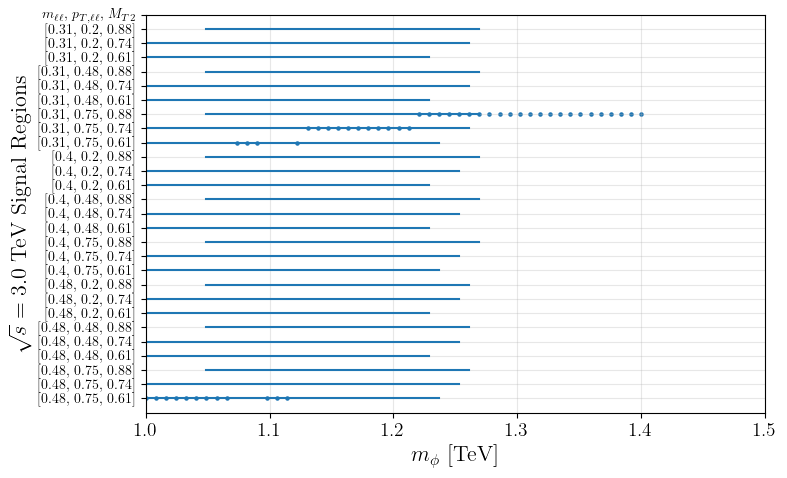

In [16]:
sr_lines_fig3 = plot_sig_ranges(rts3_runs, 1e6, SR_table_3)
# sr_lines_fig3.savefig(FIGDIR*"SR_lines_rts=3.pdf", bbox_inches="tight")
sr_lines_fig3

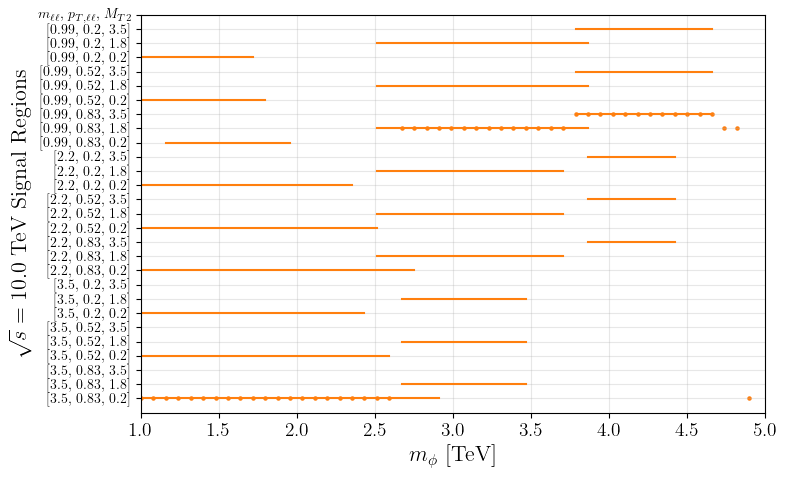

In [15]:
sr_lines_fig = plot_sig_ranges(rts10_runs, 10e6, SR_table_10; color="tab:orange")
# sr_lines_fig.savefig(FIGDIR*"SR_lines_rts=10.pdf", bbox_inches="tight")
sr_lines_fig

# Max total systematic background over all 27 SRs

In [11]:
function systematics(rts_runs, lumi, SR_table)
    N_mphi = length(rts_runs.mphis)
    N_SR = nrow(SR_table)

    mins = [Vector(SR_table[i,1:3]) for i in 1:N_SR]
    σ2s = zeros(Float64, (N_mphi,N_SR))

    for i in 1:N_mphi
        run = get_run_with_summary(rts_runs, i)

        N_Ss = N_signal.((run,), lumi, mins)
        @. N_Ss *= (N_Ss >= 20)

        N_Bs = N_background.((run,), lumi, mins)
        @. N_Bs = N_Bs + ((N_Bs <= 2.0) * (2.0-N_Bs))

        σ2s[i,:] = @. (N_Ss^2/N_Bs)/25 - 1.0
    end

    @. σ2s = σ2s + ((σ2s < 0) * NaN)

    return sqrt.(σ2s)
end

function sys_plot(rts_runs, lumi, SR_table)
    systems = systematics(rts_runs, lumi, SR_table)

    for i in eachindex(systems)
        if isnan(systems[i])
            systems[i] = 0.0
        end
    end

    sys_vv = [systems[:,i] for i in 1:27]
    sys_uni = unique(sys_vv)
    idxs = [findall(x -> x == v, sys_vv) for v in sys_uni]

    partition = Int(ceil(length(sys_uni)/3))

    f, axs = subplots(3, 1, figsize=(5, 10))

    i = 1
    j = 1
    for (k,v) in enumerate(sys_uni)
        if !(v == zero(v))
            axs[i-1].plot(1e-3*rts_runs.mphis, 100 .* v, label="SR $(idxs[k])")
        end

        j+=1

        if j > partition
            i+=1
            j=1
        end
    end

    for ax in axs
        ax.set_xlim(rts_runs.mphis[1]*1e-3, rts_runs.mphis[end]*1e-3)
        ax.set_ylim(0,100*6.25)
        ax.set_xlabel(L"$m_\phi$ [TeV]")
        ax.set_ylabel("Sys. / Stat. [\\%]")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=12, ncol=1, loc="upper left")

        x_extent = 1e-3*(rts_runs.mphis[end] - rts_runs.mphis[1])

        ax.set_aspect(x_extent / (100*6.25*golden_ratio))
    end

    f.suptitle(L"$\sqrt{s} = %$(rts_runs.rts*1e-3)$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$")

    plotclose()
    return f
end
;

In [ ]:
fsys3 = sys_plot(rts3_runs, 1e6, SR_table_3)
# fsys3.savefig(FIGDIR*"tol_sys_rts=3.pdf", bbox_inches="tight")
fsys3

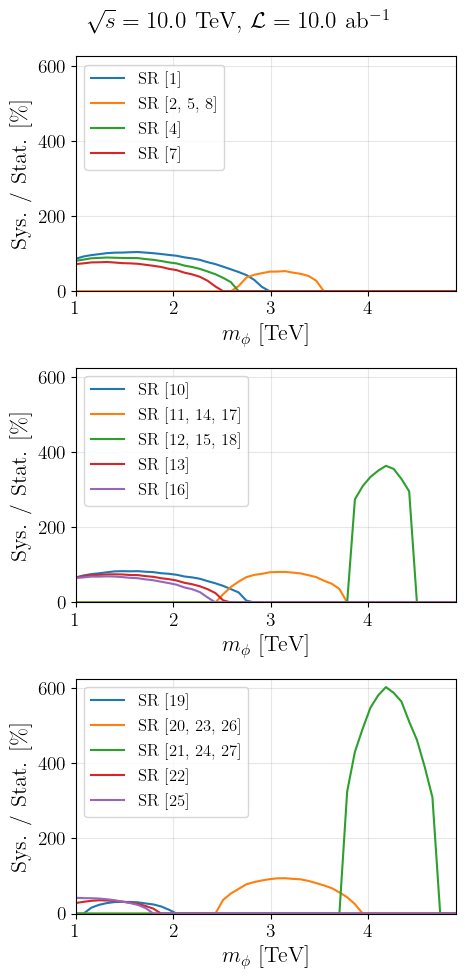

In [12]:
fsys = sys_plot(rts10_runs, 10e6, SR_table_10)
# fsys.savefig(FIGDIR*"tol_sys_rts=10.pdf", bbox_inches="tight")
fsys

# $S$ and $\sqrt{B}$ for given SR

In [18]:
function plot_S_and_B(rts_runs, lumi, mins, idx)
    N_mphi = length(rts_runs.mphis)

    N_Ss = zeros(Float64, N_mphi)
    N_B = N_background(get_run_with_summary(rts_runs, 1), lumi, mins)

    for i in 1:N_mphi
        run = get_run_with_summary(rts_runs, i)
        N_Ss[i] = N_signal(run, lumi, mins)
    end

    f = figure()
    plot(rts_runs.mphis .* 1e-3, log10.(N_Ss), label=L"S")
    axhline(log10.(5*sqrt(N_B)), label=L"5\sqrt{B}", c="tab:orange")
    xlim(rts_runs.mphis[1]*1e-3, 1e-3*rts_runs.rts/2)
    ylim(1, 4)
    xlabel(L"$m_\phi$ [TeV]")
    ylabel("Number of Events")
    grid(alpha=0.3)
    legend()

    x_extent = 1e-3*(rts_runs.rts/2 - rts_runs.mphis[1])
    y_extent = 4-1

    yticks = 1:4
    yticklabels = [L"10^{%$(round(Int, x))}" for x in yticks]

    ax = gca()
    ax.set_aspect(x_extent/(y_extent*golden_ratio), adjustable="box")
    ax.set_yticks(yticks, yticklabels)

    ax.set_title(L"SR %$(idx): [$m_{\ell \ell}$, $p_{T,\ell \ell}$, $M_{T2}$] = %$(round.(mins .* 1e-3,sigdigits=3)) TeV")

    plotclose()
    return f
end
;

In [19]:
for i in [4, 10, 13, 14]
    sr_fig = plot_S_and_B(rts10_runs, 10e6, SR_mins_10[i], i)
    sr_fig.savefig(FIGDIR*"sr$(i)_sb.pdf", bbox_inches="tight")
end
;